## Training to velocities, 1st derivatives and laplacians

In [1]:
from jax_cfd.ml.diego_cnn_bcs import *

#imports
import jax
import jax.numpy as jnp

import jax_cfd.base as cfd
from jax_cfd.ml import towers
import jax_cfd.ml.train_utils as train_utils
from jax_cfd.base import finite_differences as fd
from jax_cfd.base import grids

import haiku as hk
import numpy as np
import xarray
import random

import pickle
from diego_model_utils import SaveObject, forward_pass_module
from diego_preprocessing import *
from diego_train_functions import *

import matplotlib.pyplot as plt
import seaborn

import time

In [2]:
# import data (fine grid)
# create X_data via mean pooling
# create Y_data by calculating everything for each frame and stacking them along the channel dimension

In [3]:
# import data
file_name = '256x64_150_seconds_inner_1'
data = xarray.open_dataset(f'../../creating_dataset/datasets/'+ file_name +'.nc', chunks={'time': '100MB'})

In [4]:
# split by timestamps
x_shape = len(data.x)
y_shape = len(data.y)
high_def = []
for i in range(int(len(data.time))):
    this_time = np.dstack([
        jnp.array([data.u.isel(time = i)]).reshape(x_shape,y_shape).T,
        jnp.array([data.v.isel(time = i)]).reshape(x_shape,y_shape).T
    ])
    high_def.append(this_time)

In [5]:
#warm up time (may want to discard initial stages of simulation since not really representative of turbulent flow?)
dt = float(data.time[0].values)

outer_steps = len(data.time.values)

inner_steps = (data.time[1].values-data.time[0].values)/dt

total_sim_time = outer_steps*inner_steps*dt
print("dt: \t\t" + str(dt))
print("outer_steps: \t" + str(outer_steps))
print("inner_steps: \t" + str(inner_steps))
print("total_sim_time: " + str(total_sim_time))

warm_up = 15 #seconds
warm_index = int(warm_up/total_sim_time * outer_steps // 1)
print("removed points: " + str(warm_index))
high_def = high_def[warm_index:]

print("\n")
step = 50
high_def = high_def[0::step]
print("step = " + str(step))
print("Training dataset shape: ") # (frames, x, y, input channels)
print("\t" + str(np.shape(high_def)))

dt: 		0.015625
outer_steps: 	9600
inner_steps: 	1.0
total_sim_time: 150.0
removed points: 960


step = 50
Training dataset shape: 
	(173, 64, 256, 2)


In [6]:
%time high_def_norm,ogMean,ogStdDev = normalisingDataset(high_def)

CPU times: user 22.4 ms, sys: 1.03 ms, total: 23.5 ms
Wall time: 23.6 ms


In [7]:
#split into train and test

split = 0.8
split = int(len(high_def)*split//1)
random.shuffle(high_def)

factor = 4

print("Create X dataset: ")
%time X_dataset = creatingDataset(high_def_norm,mean_pooling,factor)

print("\nCreate Y dataset: ")
%time Y_dataset = createDatasetDerivatives(high_def_norm,sampling,factor)

# %time Y_dataset = calculateResiduals(X_dataset,Y_dataset)


X_train = X_dataset[:split]
Y_train = Y_dataset[:split]

X_test = X_dataset[split:]
Y_test = Y_dataset[split:]

# NOTE: padding conditions can be specified via the "conditions" input to the padYDataset function below
# the padXDataset only pads u and v for channel flow conditions, so hard coded for impermeability and no-slip conditions (0,0)
print("\nPadding all datasets: ")
padding = [1,1] #for a 3 by 3 kernel, find a better way to define this (so not redifined when creating CNN)
%time X_train = padXDataset(X_train,padding)
%time Y_train = padYDataset(Y_train,padding)

%time X_test = padXDataset(X_test,padding)
%time Y_test = padYDataset(Y_test,padding)

print("\nShapes of all datasets")
printAllShapes(X_train,Y_train, X_test,Y_test)

Create X dataset: 
CPU times: user 4.17 s, sys: 3.38 ms, total: 4.17 s
Wall time: 4.18 s

Create Y dataset: 
CPU times: user 892 ms, sys: 2.85 ms, total: 895 ms
Wall time: 898 ms

Padding all datasets: 
CPU times: user 2.96 s, sys: 5.6 ms, total: 2.97 s
Wall time: 2.98 s
CPU times: user 10.8 s, sys: 2 ms, total: 10.8 s
Wall time: 10.8 s
CPU times: user 683 ms, sys: 951 µs, total: 683 ms
Wall time: 686 ms
CPU times: user 2.73 s, sys: 0 ns, total: 2.73 s
Wall time: 2.74 s

Shapes of all datasets
(138, 18, 66, 2)
(138, 18, 66, 8)
(35, 18, 66, 2)
(35, 18, 66, 8)


In [8]:
padding = [1,1] # for a 3 by 3 kernel
thing = createPaddedMesh(high_def[1][:,:,1],padding)
thing = channelFlowPadding(thing,padding,0,0)

<AxesSubplot: >

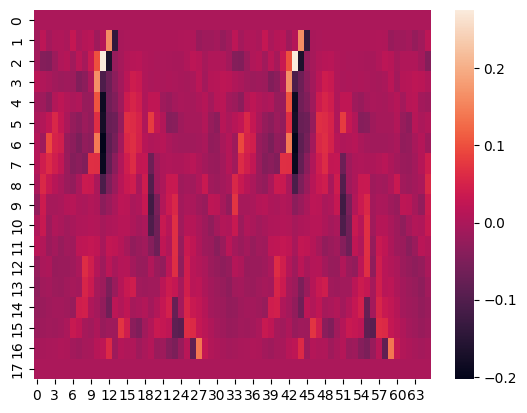

In [9]:
seaborn.heatmap(Y_test[1][:,:,7])